In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch

In [2]:
img_path = r"Abdomen\RawData\Training\img\img0035.nii.gz"
img = nib.load(img_path)
img_data = img.get_fdata()
print(img_data.shape)

label_path = r"Abdomen\RawData\Training\label\label0035.nii.gz"
label = nib.load(label_path)
label_data = label.get_fdata()
print(label_data.shape)

(512, 512, 94)
(512, 512, 94)


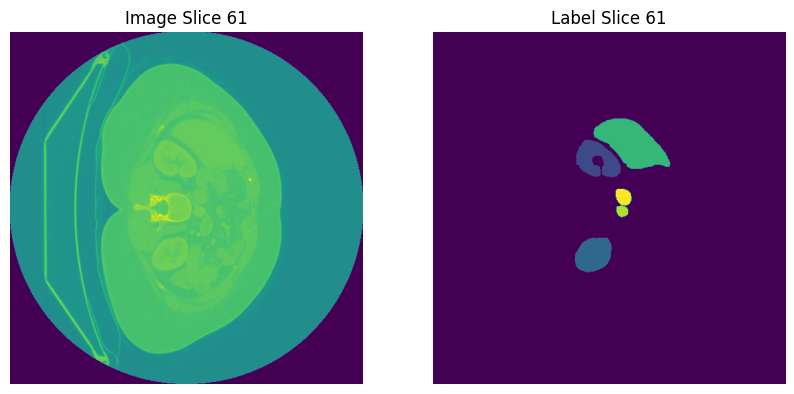

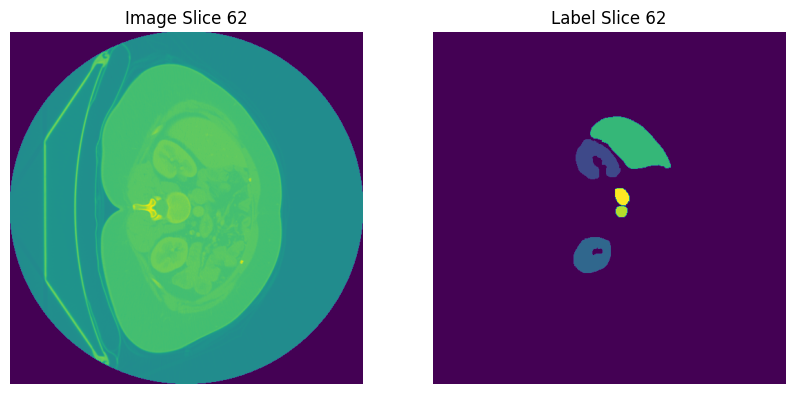

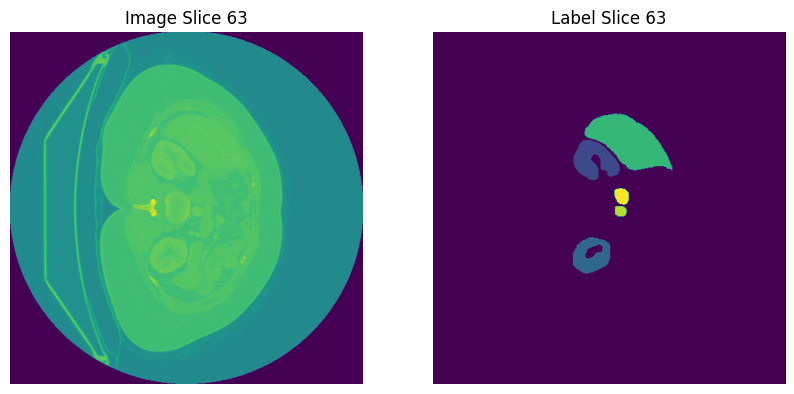

In [3]:
for i in range(60, 63):
    fig, axes = plt.subplots(1, 2, figsize=(10, 20))

    axes[0].imshow(img_data[:, :, i])
    axes[0].set_title(f'Image Slice {i+1}')
    axes[0].axis('off')

    axes[1].imshow(label_data[:, :, i])
    axes[1].set_title(f'Label Slice {i+1}')
    axes[1].axis('off')

    plt.show()


In [4]:
img_dir = r"Abdomen\RawData\Training\img"
label_dir = r"Abdomen\RawData\Training\label"

images = [os.path.join(img_dir, file) for file in os.listdir(img_dir)]
labels = [os.path.join(label_dir, file) for file in os.listdir(label_dir)]


for img_path, label_path in zip(images, labels):
    img = nib.load(img_path)
    img_data = img.get_fdata()
    label = nib.load(label_path)
    label_data = label.get_fdata()
    print(img_data.shape, label_data.shape)

(512, 512, 147) (512, 512, 147)
(512, 512, 139) (512, 512, 139)
(512, 512, 198) (512, 512, 198)
(512, 512, 140) (512, 512, 140)
(512, 512, 117) (512, 512, 117)
(512, 512, 131) (512, 512, 131)
(512, 512, 163) (512, 512, 163)
(512, 512, 148) (512, 512, 148)
(512, 512, 149) (512, 512, 149)
(512, 512, 148) (512, 512, 148)
(512, 512, 143) (512, 512, 143)
(512, 512, 89) (512, 512, 89)
(512, 512, 96) (512, 512, 96)
(512, 512, 124) (512, 512, 124)
(512, 512, 85) (512, 512, 85)
(512, 512, 131) (512, 512, 131)
(512, 512, 88) (512, 512, 88)
(512, 512, 89) (512, 512, 89)
(512, 512, 100) (512, 512, 100)
(512, 512, 153) (512, 512, 153)
(512, 512, 93) (512, 512, 93)
(512, 512, 144) (512, 512, 144)
(512, 512, 104) (512, 512, 104)
(512, 512, 98) (512, 512, 98)
(512, 512, 94) (512, 512, 94)
(512, 512, 184) (512, 512, 184)
(512, 512, 99) (512, 512, 99)
(512, 512, 100) (512, 512, 100)
(512, 512, 90) (512, 512, 90)
(512, 512, 195) (512, 512, 195)


In [5]:
from scipy.ndimage import zoom

def resize_volume(volume, target_shape=(96, 96, 96)):
    factors = np.array(target_shape) / np.array(volume.shape)    
    resized = zoom(volume, factors, order=1, mode='constant', cval=0)
    return resized

In [6]:
img_path = r"Abdomen\RawData\Training\img\img0009.nii.gz"
label_path = r"Abdomen\RawData\Training\label\label0009.nii.gz"

img = nib.load(img_path)
img_data = img.get_fdata()
label = nib.load(label_path)
label_data = label.get_fdata()

print(img_data.shape, label_data.shape)
img_resized, label_resized = resize_volume(img_data), resize_volume(label_data)
print(img_resized.shape, label_resized.shape)

(512, 512, 149) (512, 512, 149)
(96, 96, 96) (96, 96, 96)


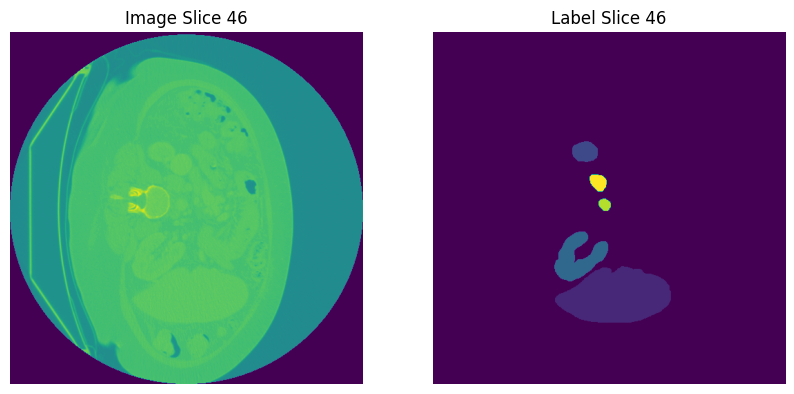

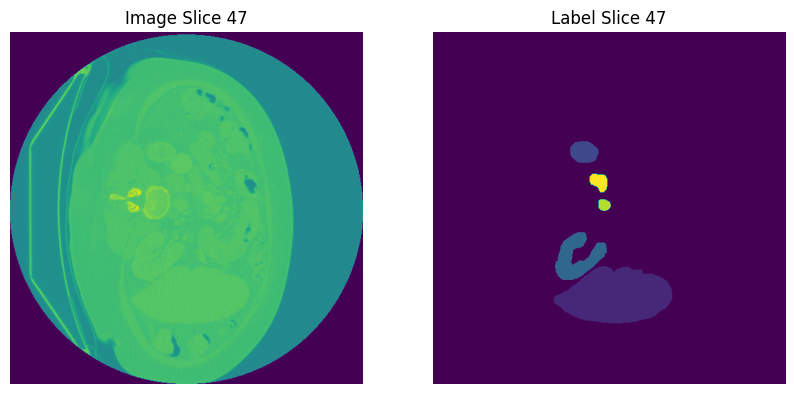

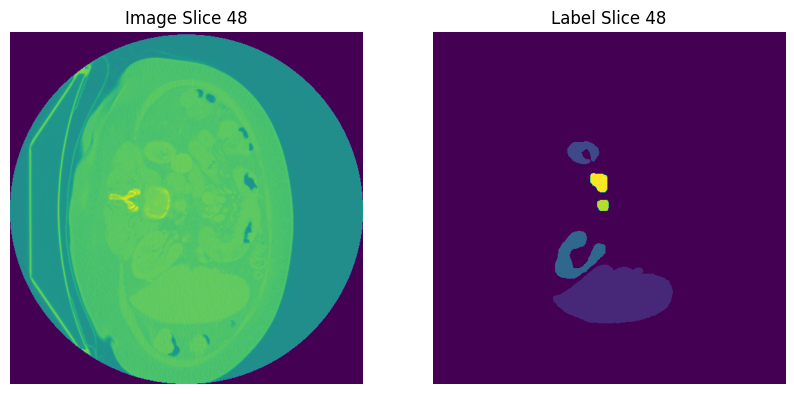

In [7]:
for i in range(45, 48):
    fig, axes = plt.subplots(1, 2, figsize=(10, 20))

    axes[0].imshow(img_data[:, :, i])
    axes[0].set_title(f'Image Slice {i+1}')
    axes[0].axis('off')

    axes[1].imshow(label_data[:, :, i])
    axes[1].set_title(f'Label Slice {i+1}')
    axes[1].axis('off')

    plt.show()

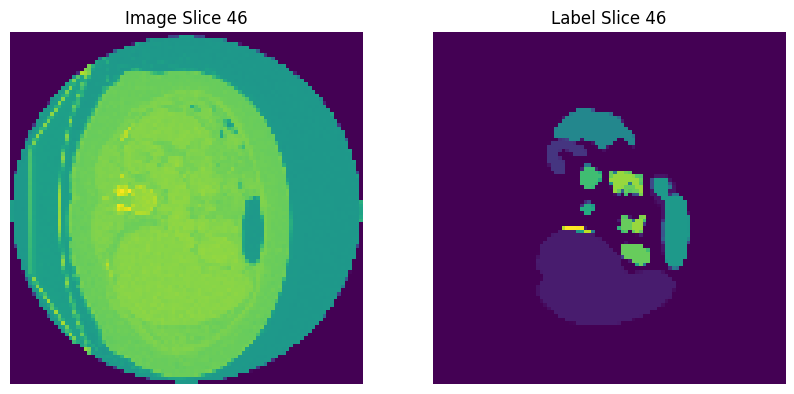

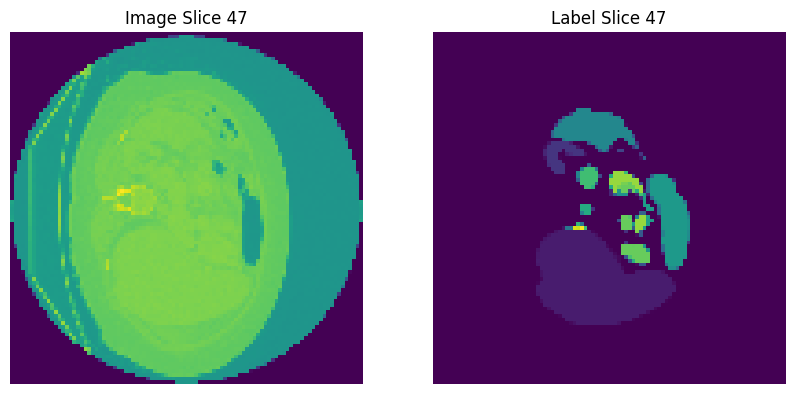

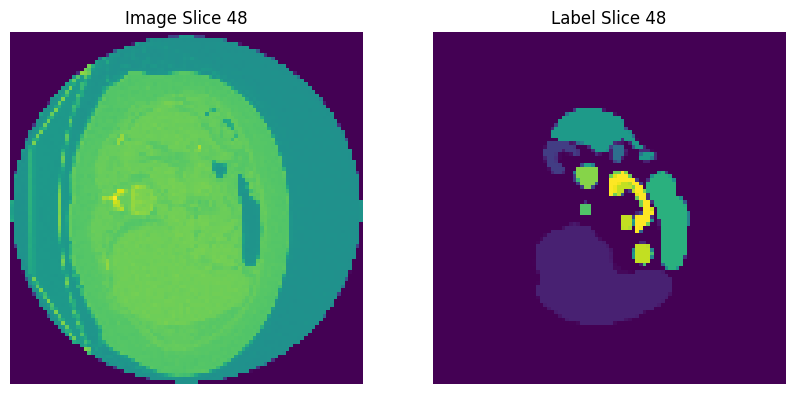

In [8]:
for i in range(45, 48):
    fig, axes = plt.subplots(1, 2, figsize=(10, 20))

    axes[0].imshow(img_resized[:, :, i])
    axes[0].set_title(f'Image Slice {i+1}')
    axes[0].axis('off')

    axes[1].imshow(label_resized[:, :, i])
    axes[1].set_title(f'Label Slice {i+1}')
    axes[1].axis('off')

    plt.show()

In [9]:
from utils import resize_vol

img, label = resize_vol(img_path), resize_vol(label_path)
print(img.shape, label.shape)
print(img.dtype, label.dtype)

torch.Size([96, 96, 96]) torch.Size([96, 96, 96])
torch.float32 torch.float32


In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from utils import resize_vol

class BTCV(Dataset):
    def __init__(self, image_dir : str, label_dir : str, transform : v2.Transform = None, target_transform : v2.Transform = None) -> None:
        self.image_dir = image_dir
        self.label_dir = label_dir

        self.img_files = sorted([file for file in os.listdir(self.image_dir) if file.endswith(".nii.gz")])
        self.label_files = sorted([file for file in os.listdir(self.label_dir) if file.endswith(".nii.gz")])

        assert len(self.img_files) == len(self.label_files)

    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        img_file, label_file = self.img_files[idx], self.label_files[idx]
        img_file_path = os.path.join(self.image_dir, img_file)
        label_file_path = os.path.join(self.label_dir, label_file)
        img = resize_vol(img_file_path)
        label = resize_vol(label_file_path)

        return img, label

In [11]:
img_dir = r"Abdomen\RawData\Training\img"
label_dir = r"Abdomen\RawData\Training\label"

dataset = BTCV(img_dir, label_dir)
print(len(dataset))

batch_size = 4
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
images, labels = next(iter(dataloader))
print(images.shape)
print(labels.shape)

30
torch.Size([4, 96, 96, 96])
torch.Size([4, 96, 96, 96])


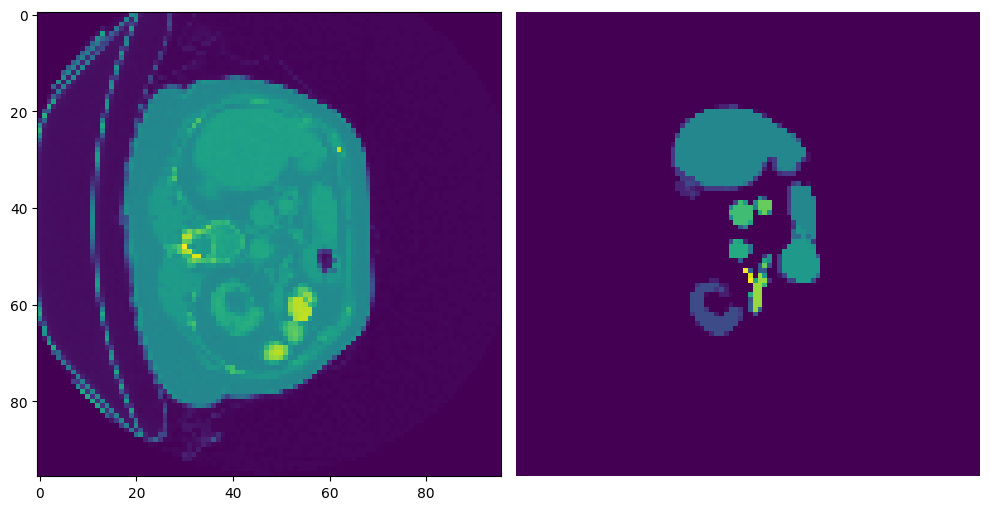

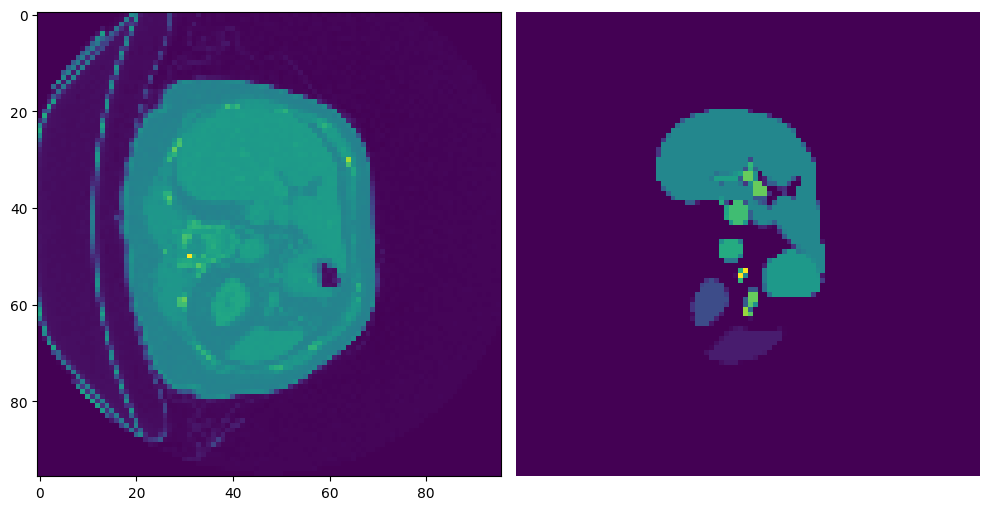

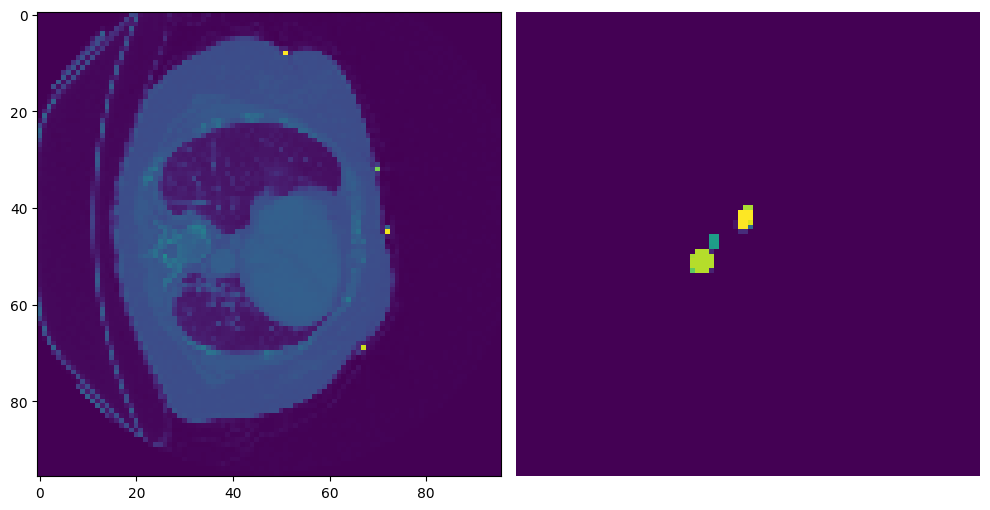

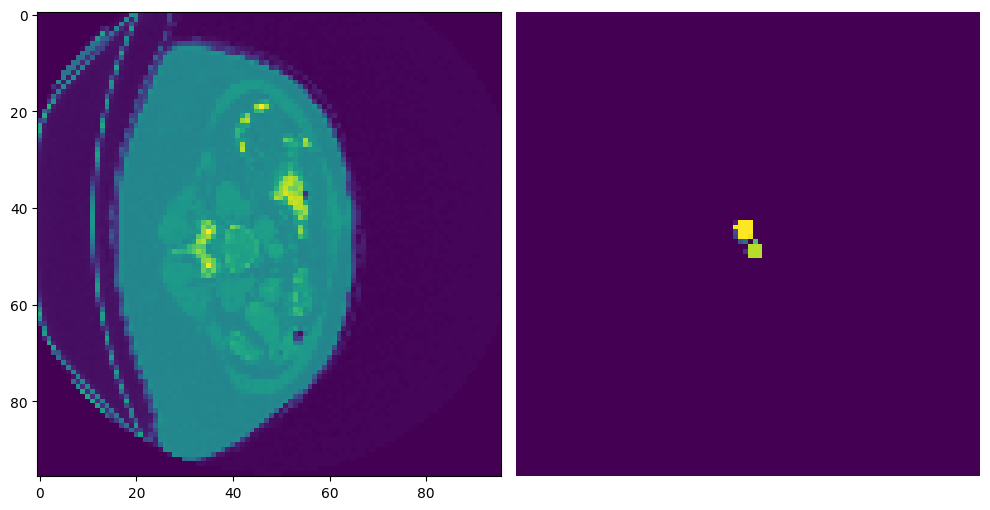

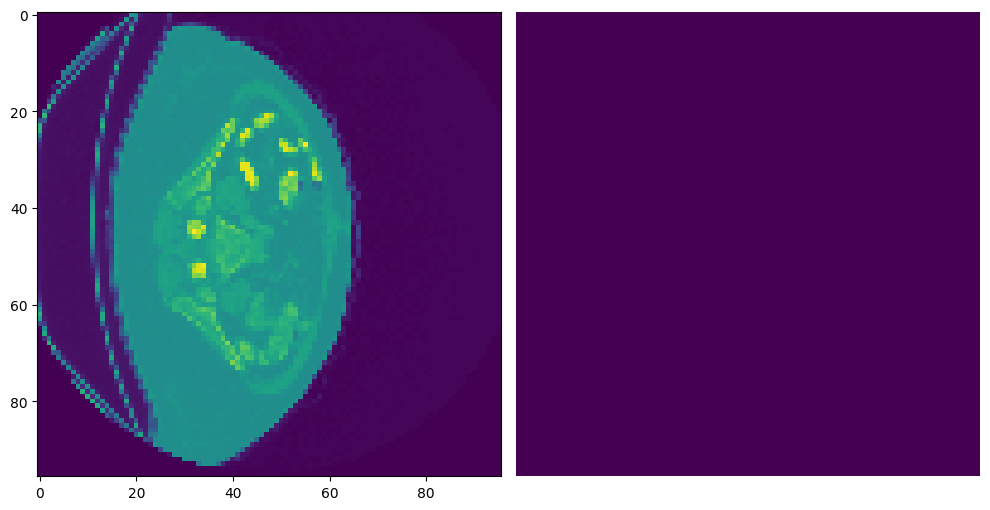

In [12]:
from utils import plot_pairs
plot_pairs(images[0], labels[0])